In [1]:
# KPMG Forecasting Project
# LT Model
# Author: Kushal Wijesundara

In [2]:
import numpy as np
import pandas as pd
import datetime
import itertools
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn import preprocessing
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
import warnings
warnings.filterwarnings("ignore")  
#require stable sktime version 0.4.3 

### Data preprocessing


In [3]:
# load data check relevant feature properties for LT model regression routines
df = pd.read_csv('mth_data_michelle.csv').sort_values('date')
df = df.set_index('date')
df = df[[col for col in df if col not in ['stock_idx_dv']] + ['stock_idx_dv']]
df.rename(columns={'stock_idx_dv':'EPS_10YR'}, inplace=True)
cln = [l[0] for l in list(filter(lambda x:x[1]>2,[(col,(df.groupby((df[col]!= 0).cumsum()).cumcount()).max()) 
 for col in df.columns]))]
df = df.drop(cln, axis = 1)
df = df.dropna(thresh=df.shape[0]*0.5,how='all',axis=1)
df = df.dropna()
df = df.apply(lambda x: [y if y <= 0.8 else 0 for y in x])
df['EPS_10YR'].replace(to_replace=0, value=np.nan, inplace=True)
df['EPS_10YR'].interpolate(inplace=True)

# take 1/3 of ts data feature selection and avoid leakage to test
df_reg = df[:int(0.3*len(df))]
split_reg = 0.1
y = df_reg.dropna().EPS_10YR
x = df_reg.dropna().drop(['EPS_10YR'], axis=1)
i = int(len(x)*(1-split_reg))
x_train = x.iloc[:i]
y_train = y.iloc[:i]
x_test = x.iloc[i:]
y_test = y.iloc[i:]

### Feature Selection

In [4]:
# xgb feature importance model
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.01,
        max_depth = 10,
        min_child_weight = 3,
        n_estimators = 200,
        subsample = 0.5)
xgb_model.fit(x_train, y_train, 
              eval_set=[(x_train, y_train), (x_test, y_test)], 
              early_stopping_rounds=50,verbose=False)
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')
feature_importance = df[[*feature_importance]]

# data for LT model
df = pd.merge(feature_importance, df.EPS_10YR, how='outer', on='date')
df.index = pd.to_datetime(df.index)
colist = list(df.columns.values)
df = df.dropna()

### LT parameter selection - Model Demonstration

In [6]:
# define window (72 months) for long-term (18 months) prediction.  
# split date defines the test data start year

window = 72
steps = 18
split_date = "2018-03-01"

### Regression strategy

In [7]:
# define pipelined forecaster with deseasonalizer and regression strategy

# ReducedRegressionForecaster class in python object oriented programming utilize recursive reduction algorithm for forecasting. 
# First rolling window approach is used to transform the target series into panel data
# For the recursive reduction strategy, a single estimator is fit for a one-step-ahead forecasting horizon 
# and call iteratively to predict multiple steps ahead (reference 
# https://github.com/alan-turing-institute/sktime/blob/v0.5.2/sktime/forecasting/compose/_reduce.py#L484-L510)

# The class TransformedTargetForecaster works as a Meta-estimator for forecasting transformed time series
# (reference https://github.com/alan-turing-institute/sktime/blob/v0.4.2/sktime/forecasting/compose/_pipeline.py#L19-L197)

def target_forecast(val,var):
    reg_model = RandomForestRegressor(n_estimators=2*steps, max_depth=steps, random_state=2)
    pred = TransformedTargetForecaster([("1", Deseasonalizer(sp=len(fh), model="additive")),("2",ReducedRegressionForecaster(reg_model, 
                    strategy="recursive",window_length=window))])
    return pred

In [8]:
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.squeeze(), test_size=split)
def get_gscv(train):
    cv = SlidingWindowSplitter(
        initial_window=int(len(train)),
        start_with_window=True,
    )
    param_grid = {
        "n_estimators": [0.5*steps, steps, 2*steps],
        "max_depth": [0.5*steps, steps, 2*steps],
    }
    gscv = ForecastingGridSearchCV(target_forecast, cv=cv, param_grid=param_grid, scoring=MetricFunctionWrapper(mean_absolute_error))
    return gscv

### Model train and prediction

In [9]:
# train model and predict target forecasts
forecasts = []
for index, col in df.iteritems():
    col.index = col.index.to_period('M') 
    train, test = temporal_train_test_split(col, test_size=split)
    fh = list(range(1,1+steps))
    var = {'param':'avg'}
    avg = [.5] 
    for val in avg:
        pred = target_forecast(val,var)
        fh = fh
        pred.fit(train)
        pred = pred.predict(fh)
        forecasts.append(pred)
forecasts = pd.concat([pd.DataFrame(forecasts).T])
forecasts = forecasts.rename(columns=dict(zip(forecasts.columns,colist)))
forecasts.rename(columns={'EPS_10YR':'EPS_10YR_fore'}, inplace=True)
forecasts = forecasts.reset_index()
forecasts = forecasts.rename(columns={'index':'date'})
forecasts = forecasts.set_index('date')

# cross-sectional regression
y_ = forecasts.EPS_10YR_fore.values
x_ = forecasts.drop(forecasts.iloc[:, np.r_[1, 2:]], axis = 1).assign(constant=1).values
i = steps
reg = []
for n in range(i,len(forecasts)):
    y = y_[(n - i):n]
    X = x_[(n - i):n]
    reg.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).dot(x_[n, :]))
y_reg=pd.concat([pd.DataFrame(reg, columns=['EPS_10YR_reg'])])
# Ensemble
fore_results = forecasts[['EPS_10YR_fore']].reset_index()
reg_results = fore_results.merge(y_reg, left_index=True, right_index=True)
reg_results = reg_results.set_index('date')
reg_results = reg_results[['EPS_10YR_reg']]
ensemble = pd.merge(forecasts,reg_results, how='outer', on='date').reset_index()
ensemble = ensemble.assign(EPS_10YR_pred = ensemble.loc[:, ["EPS_10YR_fore", "EPS_10YR_reg"]].mean(axis=1)).set_index('date')
LT_pred_results = ensemble[['EPS_10YR_pred']]
result = pd.merge(df.EPS_10YR,LT_pred_results, how='outer', on='date')
results = result.dropna()

In [10]:
# Error metric
results['MAPE'] = ((results.EPS_10YR-results.EPS_10YR_pred).abs()
                 .div(results.EPS_10YR)
                 .cumsum()
                 /np.arange(1,len(results)+1)
             )
abs(results["MAPE"].mean())

0.028584519117901646

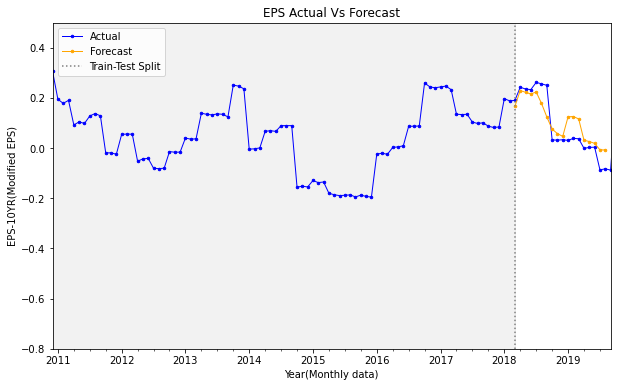

In [11]:
plt.figure(figsize=(10,6))
ax1 = df.EPS_10YR.plot(color='blue',label='Actual', linestyle="-",marker='o', markersize=2.5, linewidth=1)
ax2 = LT_pred_results.EPS_10YR_pred.plot(color='orange', label='Forecast', marker='o', markersize=2.5, linewidth=1)
ax1.set_ylabel('EPS-10YR(Modified EPS)')
ax1.set_xlabel('Year(Monthly data)')
ax1.set_xlim([datetime.date(2010,12,1), datetime.date(2019,9,1)])
ax1.set_ylim([-0.8, 0.5])
plt.title('EPS Actual Vs Forecast')
plt.axvline(pd.Timestamp(split_date),color="grey", linestyle=":", label = 'Train-Test Split')
plt.axvspan(pd.Timestamp(split_date), pd.Timestamp(window), alpha=0.1, color='grey')
plt.legend()
plt.show()

### Future forecast

In [12]:
#(Proof) LT model only uses past data for future forecasts.
df.index = pd.to_datetime(df.index).to_period('M')
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.iloc[:,-1], test_size=split)
future_forecasts = []
fh = list(range(1,1+steps))
var = {'param':'avg'}
avg = [.5] 
for val in avg:
    pred = target_forecast(val,var)
    fh = list(range(2*steps,3*steps))
    pred.fit(train)
    pred = pred.predict(fh)
    future_forecasts.append(pred)
f_forecasts = pd.concat([pd.DataFrame(future_forecasts)])
print(f_forecasts.T.reset_index())

      index         0
0   2021-02  0.011545
1   2021-03  0.005772
2   2021-04  0.116887
3   2021-05  0.123902
4   2021-06  0.152234
5   2021-07  0.200317
6   2021-08  0.201698
7   2021-09  0.192255
8   2021-10  0.174326
9   2021-11  0.145408
10  2021-12  0.123970
11  2022-01  0.160815
12  2022-02  0.116770
13  2022-03  0.099805
14  2022-04  0.030770
15  2022-05  0.031838
16  2022-06  0.033794
17  2022-07  0.024869


### Data Generation for Sector-Specific Models (to combine with ST model)

In [13]:
# The entire data set with required exogenous variables span from 1990-2021 for the LT model
# Sector-specific models require LT model results from the year 2003, which translates to 45 % train and 55 % test.
# Having 45% train and 55% test is extremely unreliable. Therefore similar to short term model, 
# LT model adopted predicting from a cutoff point to cutoff+horizon. The time before cutoff point, 
# is the initial/lookback period, which is the training set. By translating the cutoff point from 2003-09-01
# by 18 months (i.e. 2003-09-01,2005-02-01,..) We obtained the required data (save to csv) and combined it to use 4
# for ensemble modeling.

In [14]:
cutoff_point = "2003-09-01"
cutoff = len(df.loc[cutoff_point:])/len(df)
forecasts = []
for index, col in df.iteritems():
    #col.index = col.index.to_period('M') 
    train, test = temporal_train_test_split(col, test_size=cutoff)
    fh = list(range(1,1+steps))
    var = {'param':'avg'}
    avg = [.5] 
    for val in avg:
        pred = target_forecast(val,var)
        fh = fh
        pred.fit(train)
        pred = pred.predict(fh)
        forecasts.append(pred)
forecasts = pd.concat([pd.DataFrame(forecasts).T])
forecasts = forecasts.rename(columns=dict(zip(forecasts.columns,colist)))
forecasts.rename(columns={'EPS_10YR':'EPS_10YR_fore'}, inplace=True)
forecasts = forecasts.reset_index()
forecasts = forecasts.rename(columns={'index':'date'})
forecasts = forecasts.set_index('date')
y_ = forecasts.EPS_10YR_fore.values
x_ = forecasts[['vix']].assign(constant=1).values
i = steps
reg = []
for n in range(i,len(forecasts)):
    y = y_[(n - i):n]
    X = x_[(n - i):n]
    reg.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).dot(x_[n, :]))
y_reg=pd.concat([pd.DataFrame(reg, columns=['EPS_10YR_reg'])])
fore_results = forecasts[['EPS_10YR_fore']].reset_index()
reg_results = fore_results.merge(y_reg, left_index=True, right_index=True)
reg_results = reg_results.set_index('date')
reg_results = reg_results[['EPS_10YR_reg']]
ensemble = pd.merge(forecasts,reg_results, how='outer', on='date').reset_index()
ensemble = ensemble.assign(EPS_10YR_pred = ensemble.loc[:, ["EPS_10YR_fore", "EPS_10YR_reg"]].mean(axis=1)).set_index('date')
LT_pred_results = ensemble[['EPS_10YR_pred']]
result = pd.merge(df.EPS_10YR,LT_pred_results, how='outer', on='date')
results = result.dropna()

In [15]:
results.to_csv('LTsec1.csv')